# ✅ Your Objective
**Improve generalization with more data and smarter learning**

---

## 📌 Plan Summary

### 1. 📈 Data Augmentation

✅ Use `ImageDataGenerator` (Keras) or `tf.keras.layers.Rescaling` + `Random*` (for `tf.data`)

**Augmentations to use:**

- `rotation_range=10–15`
- `width_shift_range=0.1`
- `height_shift_range=0.1`
- `zoom_range=0.1`
- `shear_range=0.1`
- `horizontal_flip=False` _(MNIST is sensitive to flips)_
- `rescale=1./255` _(always normalize)_

---

### 2. 🧠 Base CNN Model

- Simple architecture: `Conv + ReLU + Pool → Dense → Dropout → Softmax`
- ✅ Add `BatchNormalization` after Conv layers
- ✅ Use `Dropout` (range `0.3–0.5`) to avoid overfitting

---

### 3. 🔁 Transfer Learning

Since MNIST is grayscale (1 channel), two options:

#### 🧠 Option A: Use Pretrained CNNs on Grayscale (Adjusted Input)

- Convert 1 channel → 3 channels using:
  - `.repeat(3, axis=-1)`  
  - or a `Conv2D` layer
- Use lightweight pretrained models:
  - `MobileNetV2`
  - `EfficientNetB0`
  - `ResNet50` _(overkill but works)_
- Use only the feature extractor (`include_top=False`)
- ✅ Freeze the base for the first few epochs

#### ⚡ Option B: Custom CNN + Transfer Learning

- Build your own CNN
- Freeze the **bottom few layers**
- Train top layers with new data / augmentations

---

## 🔥 Suggestions Before You Code

✅ Add:

- `EarlyStopping` (`patience=5`)
- `ModelCheckpoint` (monitor `val_accuracy`)
- `LearningRateScheduler` or `ReduceLROnPlateau`

📊 Track:

- Training / Validation Accuracy
- Misclassified images on validation
- Use **TensorBoard** or `matplotlib` to visualize

---

## 🧠 Bonus (Optional)

- Try **Mixup** or **CutMix** (advanced augmentations)
- Use **data balancing** if needed  
  _(not required here — MNIST is balanced)_
- Use **Keras Tuner** for base CNN only  
  _(for TL, keep it simple)_

---


In [1]:
# 1. 🔧 Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import os
import datetime

2025-07-05 17:54:53.813603: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751738094.076523      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751738094.155795      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# 2. 📥 Load CSV and reshape to 28x28x1
def load_mnist_data(path='data/train.csv'):
    df = pd.read_csv(path)
    X = df.drop('label', axis=1).values.reshape(-1, 28, 28, 1)
    y = df['label'].values
    X = X / 255.0
    return X, y

In [3]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

def split_and_augment(X, y, augment=True):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)
    
    y_train_cat = to_categorical(y_train, num_classes=10)
    y_val_cat = to_categorical(y_val, num_classes=10)

    if augment:
        datagen = ImageDataGenerator(
            rotation_range=12,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.1,
            shear_range=0.1
        )
        datagen.fit(X_train)
    else:
        datagen = None

    return X_train, X_val, y_train_cat, y_val_cat, y_val, datagen


In [4]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

def split_and_augment(X, y, augment=True):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)
    
    y_train_cat = to_categorical(y_train, num_classes=10)
    y_val_cat = to_categorical(y_val, num_classes=10)

    if augment:
        datagen = ImageDataGenerator(
            rotation_range=12,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.1,
            shear_range=0.1
        )
        datagen.fit(X_train)
    else:
        datagen = None

    return X_train, X_val, y_train_cat, y_val_cat, y_val, datagen


In [5]:
def build_base_cnn():
    model = keras.Sequential([
        layers.Input(shape=(28, 28, 1)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(10, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [6]:
def get_callbacks(model_path='models/cnn_aug_best.h5'):
    return [
        EarlyStopping(patience=6, restore_best_weights=True, monitor='val_accuracy'),
        ModelCheckpoint(model_path, save_best_only=True, monitor='val_accuracy', verbose=1),
        ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1)
    ]


In [7]:
def train_model(model, X_train, y_train, X_val, y_val, datagen=None, callbacks=[], batch_size=64, epochs=50):
    if datagen:
        history = model.fit(
            datagen.flow(X_train, y_train, batch_size=batch_size),
            validation_data=(X_val, y_val),
            epochs=epochs,
            callbacks=callbacks,
            verbose=2
        )
    else:
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            batch_size=batch_size,
            epochs=epochs,
            callbacks=callbacks,
            verbose=2
        )

    return model, history


In [8]:
def evaluate_and_plot(model, X_val, y_val_cat, y_val_true, class_names=list(range(10))):
    y_pred = np.argmax(model.predict(X_val), axis=1)
    acc = np.mean(y_pred == y_val_true)
    print(f"✅ Validation Accuracy: {acc:.5f}")
    print("\n📄 Classification Report:\n", classification_report(y_val_true, y_pred))

    cm = confusion_matrix(y_val_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # 🔍 Show 12 misclassified images
    misclassified_idx = np.where(y_pred != y_val_true)[0][:12]
    plt.figure(figsize=(12, 4))
    for i, idx in enumerate(misclassified_idx):
        plt.subplot(2, 6, i + 1)
        plt.imshow(X_val[idx].reshape(28, 28), cmap='gray')
        plt.title(f"True: {y_val_true[idx]}, Pred: {y_pred[idx]}")
        plt.axis('off')
    plt.suptitle("Misclassified Digits")
    plt.tight_layout()
    plt.show()


In [9]:
def predict_and_submit(model, test_path='data/test.csv', output_path='outputs/cnn_base_aug_predictions.csv'):
    test_df = pd.read_csv(test_path)
    X_test = test_df.values.reshape(-1, 28, 28, 1) / 255.0

    preds = np.argmax(model.predict(X_test), axis=1)
    submission = pd.DataFrame({'ImageId': np.arange(1, len(preds)+1), 'Label': preds})
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    submission.to_csv(output_path, index=False)
    print("📦 Saved predictions to:", output_path)


I0000 00:00:1751738112.603708      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1751738117.164393      78 service.cc:148] XLA service 0x7f55d4004a30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751738117.165383      78 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751738117.535292      78 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1751738120.390920      78 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_accuracy improved from -inf to 0.95833, saving model to models/cnn_aug_best.h5
591/591 - 20s - 34ms/step - accuracy: 0.8629 - loss: 0.4405 - val_accuracy: 0.9583 - val_loss: 0.1300 - learning_rate: 0.0010
Epoch 2/50

Epoch 2: val_accuracy did not improve from 0.95833
591/591 - 11s - 18ms/step - accuracy: 0.9453 - loss: 0.1813 - val_accuracy: 0.8850 - val_loss: 0.4065 - learning_rate: 0.0010
Epoch 3/50

Epoch 3: val_accuracy improved from 0.95833 to 0.97429, saving model to models/cnn_aug_best.h5
591/591 - 10s - 18ms/step - accuracy: 0.9593 - loss: 0.1348 - val_accuracy: 0.9743 - val_loss: 0.0771 - learning_rate: 0.0010
Epoch 4/50

Epoch 4: val_accuracy improved from 0.97429 to 0.98476, saving model to models/cnn_aug_best.h5
591/591 - 10s - 18ms/step - accuracy: 0.9645 - loss: 0.1169 - val_accuracy: 0.9848 - val_loss: 0.0506 - learning_rate: 0.0010
Epoch 5/50

Epoch 5: val_accuracy improved from 0.98476 to 0.98929, saving model to models/cnn_aug_best.h5
591/591 - 11s - 18m

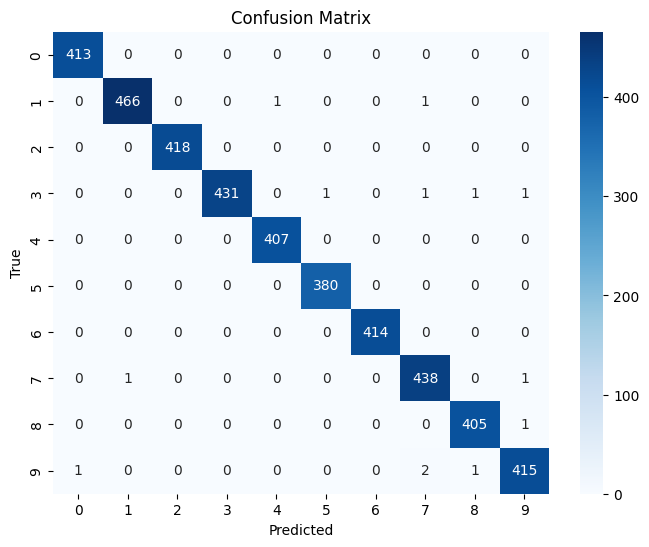

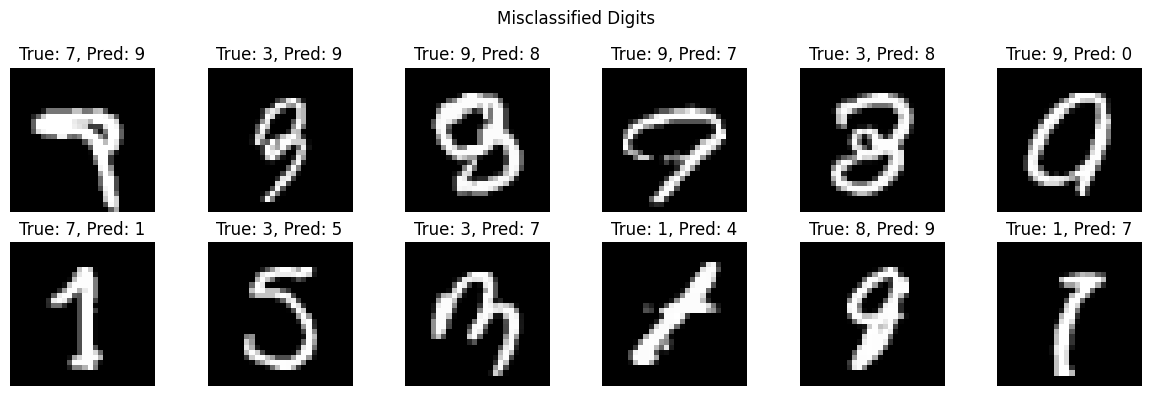

In [10]:
# Execution
X, y = load_mnist_data('/kaggle/input/digit-recognizer/train.csv')
X_train, X_val, y_train_cat, y_val_cat, y_val_true, datagen = split_and_augment(X, y)
model = build_base_cnn()
callbacks = get_callbacks()
model, history = train_model(model, X_train, y_train_cat, X_val, y_val_cat, datagen, callbacks)
evaluate_and_plot(model, X_val, y_val_cat, y_val_true)

In [11]:
predict_and_submit(model, test_path = '/kaggle/input/digit-recognizer/test.csv')

875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
📦 Saved predictions to: outputs/cnn_base_aug_predictions.csv


### TL technique

In [12]:
# 📦 Core Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import os

# ✅ Reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# 📂 Create output folders if not exist
os.makedirs("outputs/models", exist_ok=True)
os.makedirs("outputs/submissions", exist_ok=True)

In [13]:
def load_and_preprocess_data(path='data/train.csv', img_size=96):
    df = pd.read_csv(path)
    X = df.drop('label', axis=1).values.reshape(-1, 28, 28, 1)
    y = to_categorical(df['label'], num_classes=10)

    # Resize to (96, 96) and convert grayscale → RGB
    X_resized = tf.image.resize(X, [img_size, img_size]).numpy()
    X_rgb = np.repeat(X_resized, 3, axis=-1)

    return train_test_split(X_rgb, y, test_size=0.1, stratify=y.argmax(axis=1), random_state=42)

In [14]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras import layers, models
import tensorflow as tf

def build_tl_model(img_size=96, learning_rate=1e-3, trainable=False, trainable_layers=5):
    # 1. Load pretrained MobileNetV2
    base_model = MobileNetV2(
        input_shape=(img_size, img_size, 3),
        include_top=False,
        weights='imagenet'
    )

    # 2. Freeze all layers initially
    base_model.trainable = False

    
    # 3. Unfreeze top N layers
    if trainable:
        for layer in base_model.layers[-trainable_layers:]:
            layer.trainable = True

    # 4. Build the model
    model = models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(img_size, img_size, 3)),
        tf.keras.layers.Lambda(preprocess_input),  # ✅ normalize using MobileNet's preprocessing
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(10, activation='softmax')  # Use sparse_categorical_crossentropy if y are integer labels
    ])

    # 5. Compile
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',  # If labels are integers (0–9)
        metrics=['accuracy']
    )

    return model


In [15]:
def train_tl_model(model, X_train, y_train, X_val, y_val, model_name='cnn_aug_with_TL'):
    aug = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        shear_range=0.1,
        horizontal_flip=False,
        preprocessing_function=preprocess_input
    )

    checkpoint = callbacks.ModelCheckpoint(
        f"outputs/models/{model_name}.h5",
        save_best_only=True,
        monitor='val_accuracy',
        mode='max'
    )
    earlystop = callbacks.EarlyStopping(
        patience=3,
        restore_best_weights=True,
        monitor='val_accuracy'
    )

    history = model.fit(
        aug.flow(X_train, y_train, batch_size=512),
        validation_data=(preprocess_input(X_val), y_val),
        epochs=25,
        callbacks=[checkpoint, earlystop],
        verbose=2
    )
    return history


In [ ]:
X_train, X_val, y_train, y_val = load_and_preprocess_data('/kaggle/input/digit-recognizer/train.csv')
model = build_tl_model()
history = train_tl_model(model, X_train, y_train, X_val, y_val)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


E0000 00:00:1751738575.287843      77 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751738575.479659      77 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751738575.754863      77 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751738575.973047      77 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751738622.453052      78 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

74/74 - 112s - 2s/step - accuracy: 0.1892 - loss: 2.2611 - val_accuracy: 0.3233 - val_loss: 2.0775
Epoch 2/25
74/74 - 83s - 1s/step - accuracy: 0.2924 - loss: 2.0113 - val_accuracy: 0.4693 - val_loss: 1.8297
Epoch 3/25
74/74 - 82s - 1s/step - accuracy: 0.3626 - loss: 1.8335 - val_accuracy: 0.5871 - val_loss: 1.6213
Epoch 4/25
74/74 - 82s - 1s/step - accuracy: 0.4224 - loss: 1.6835 - val_accuracy: 0.6360 - val_loss: 1.4375
Epoch 5/25
74/74 - 83s - 1s/step - accuracy: 0.4770 - loss: 1.5423 - val_accuracy: 0.6886 - val_loss: 1.2959
Epoch 6/25
74/74 - 82s - 1s/step - accuracy: 0.5166 - loss: 1.4312 - val_accuracy: 0.7105 - val_loss: 1.1725
Epoch 7/25
74/74 - 82s - 1s/step - accuracy: 0.5460 - loss: 1.3454 - val_accuracy: 0.7481 - val_loss: 1.0483
Epoch 8/25
74/74 - 82s - 1s/step - accuracy: 0.5748 - loss: 1.2701 - val_accuracy: 0.7617 - val_loss: 0.9764
Epoch 9/25
74/74 - 82s - 1s/step - accuracy: 0.5930 - loss: 1.2110 - val_accuracy: 0.7748 - val_loss: 0.8972
Epoch 10/25


In [ ]:
def plot_misclassified(X_val, y_true, y_pred, max_display=16):
    misclassified = np.where(y_true != y_pred)[0]
    print(f"🔍 Total misclassified: {len(misclassified)}")

    plt.figure(figsize=(12, 12))
    for i, idx in enumerate(misclassified[:max_display]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(X_val[idx].astype('uint8'))
        plt.title(f"True: {y_true[idx]}, Pred: {y_pred[idx]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

y_true, y_pred = evaluate_model(model, X_val, y_val)
plot_misclassified(X_val, y_true, y_pred)

In [ ]:
def evaluate_model(model, X_val, y_val):
    preds = model.predict(preprocess_input(X_val))
    y_true = y_val.argmax(axis=1)
    y_pred = preds.argmax(axis=1)

    print("Validation Accuracy:", np.mean(y_true == y_pred))
    return y_true, y_pred

def preprocess_test_data(path='data/test.csv', img_size=96):
    test_df = pd.read_csv(path)
    X_test = test_df.values.reshape(-1, 28, 28, 1)
    X_resized = tf.image.resize(X_test, [img_size, img_size]).numpy()
    X_rgb = np.repeat(X_resized, 3, axis=-1)
    return preprocess_input(X_rgb)

def predict_and_submit(model, test_data, submission_path='outputs/submissions/cnn_aug_with_TL.csv'):
    predictions = model.predict(test_data)
    predicted_labels = predictions.argmax(axis=1)

    submission = pd.DataFrame({
        "ImageId": np.arange(1, len(predicted_labels) + 1),
        "Label": predicted_labels
    })
    submission.to_csv(submission_path, index=False)
    print(f"✅ Submission saved to {submission_path}")

# Load and preprocess test data
X_test = preprocess_test_data('/kaggle/input/digit-recognizer/test.csv')

# Load best model if needed
# from tensorflow.keras.models import load_model
# model = load_model("outputs/models/cnn_aug_with_TL.h5")

# Predict and save
predict_and_submit(model, X_test)
